In [1]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 15 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 3
cfg['set_id'] = 3

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [5]:
from dataloader import *
from models import *
import time

model = LSTM_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

#optimizer = torch.optim.RMSprop(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])
#optimizer = torch.optim.Adadelta(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [6]:
model.train()

LSTM_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (lstm): LSTM(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 0.70360
count = 4, loss = 0.70884
count = 6, loss = 0.32025
count = 8, loss = 0.47326
count = 10, loss = 0.32392
count = 12, loss = 0.38961
count = 14, loss = 0.36599
validation loss: 0.3000406362116337
epoch finished: 1
count = 2, loss = 0.33911
count = 4, loss = 0.37798
count = 6, loss = 0.31899
count = 8, loss = 0.34179
count = 10, loss = 0.28248
count = 12, loss = 0.32906
count = 14, loss = 0.31596
validation loss: 0.24380934983491898
epoch finished: 2
count = 2, loss = 0.29814
count = 4, loss = 0.31534
count = 6, loss = 0.29570
count = 8, loss = 0.29868
count = 10, loss = 0.27351
count = 12, loss = 0.25751
count = 14, loss = 0.37781
validation loss: 0.23867466673254967
epoch finished: 3
count = 2, loss = 0.29023
count = 4, loss = 0.32752
count = 6, loss = 0.28630
count = 8, loss = 0.34693
count = 10, loss = 0.28596
count = 12, loss = 0.30040
count = 14, loss = 0.24802
validation loss: 0.21604442968964577
epoch finished: 4
count = 2, loss = 0.29830
count = 4, loss

In [8]:
np.save('val_loss_set3.npy', val_losses)
np.save('train_loss_set3.npy', train_losses)

In [10]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.22859857603907585
validation MAE: 0.12602121755480766
QWK Score: 0.7511271415689811


In [11]:
targets

[array([2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 3, 3, 2, 2, 3, 1, 1, 3, 2, 1,
        2, 2, 1, 2, 3, 2, 3, 1, 2, 3, 3, 1, 1, 1, 1, 2, 3, 1, 2, 3, 2, 2,
        3, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 3, 1, 1, 2, 2, 1, 2,
        2, 2, 2, 1, 3, 3, 2, 2, 2, 1, 1, 3, 1, 2, 3, 3, 3, 2, 1, 3, 1, 0,
        2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 3, 3, 2, 3, 1, 2, 2, 3,
        3, 3, 3, 1, 1, 0, 2, 1, 3, 2]),
 array([3, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2,
        1, 2, 3, 2, 1, 3, 3, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 2, 1, 2, 1, 2,
        3, 2, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 2, 2, 2, 3, 2, 1, 3, 2, 2,
        2, 2, 1, 2, 2, 3, 3, 2, 2, 1, 3, 3, 2, 2, 1, 2, 2, 3, 2, 1, 1, 3,
        1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 3, 1, 2, 3, 1, 3, 1, 2,
        3, 0, 1, 3, 2, 3, 3, 1, 2, 1]),
 array([2, 3, 2, 2, 3, 2, 3, 1, 3, 3, 0, 3, 2, 3, 3, 2, 1, 2, 3, 3, 3, 1,
        3, 1, 3, 3, 3, 1, 2, 2, 1, 2, 3, 1, 2, 3, 3, 1, 1, 1, 2, 1, 1, 1,
        3, 3, 3, 3, 2, 1, 3, 1, 

In [12]:
preds

[array([2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 3, 2, 2, 1, 2, 1, 1, 2, 2, 2,
        3, 2, 1, 2, 2, 2, 3, 1, 2, 3, 3, 1, 1, 2, 1, 1, 3, 1, 2, 2, 2, 2,
        3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 3, 2, 1, 1, 3, 3, 2, 1, 2, 3, 1, 2,
        2, 2, 2, 1, 3, 3, 2, 2, 2, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 2, 1,
        2, 2, 2, 3, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 3, 3, 2, 3, 1, 2, 1, 3,
        2, 2, 3, 1, 1, 1, 1, 1, 3, 3]),
 array([3, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 2, 2, 3, 3, 1,
        1, 2, 3, 2, 1, 3, 2, 2, 1, 1, 2, 1, 2, 2, 3, 3, 3, 3, 1, 2, 1, 3,
        3, 2, 2, 1, 3, 2, 3, 2, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        3, 1, 1, 2, 2, 3, 3, 3, 2, 1, 3, 3, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2,
        1, 2, 2, 1, 2, 2, 2, 1, 3, 1, 2, 2, 1, 1, 3, 1, 2, 3, 1, 3, 1, 2,
        3, 1, 1, 3, 2, 3, 3, 1, 2, 1]),
 array([2, 1, 1, 2, 3, 3, 2, 1, 2, 3, 1, 3, 2, 3, 2, 3, 1, 2, 2, 3, 2, 1,
        3, 1, 3, 2, 3, 1, 2, 2, 1, 2, 3, 1, 2, 3, 3, 1, 2, 2, 2, 1, 1, 2,
        3, 2, 3, 2, 1, 1, 2, 1, 

In [13]:
train_losses

[0.7036015391349792,
 0.70884008705616,
 0.32024987041950226,
 0.4732557237148285,
 0.32391758263111115,
 0.3896060883998871,
 0.36598896980285645,
 0.3391140401363373,
 0.3779752403497696,
 0.31898774206638336,
 0.3417889475822449,
 0.282478466629982,
 0.32906465977430344,
 0.31596098840236664,
 0.2981441468000412,
 0.31533853709697723,
 0.29570172727108,
 0.2986771762371063,
 0.27351298928260803,
 0.25750815123319626,
 0.3778075873851776,
 0.29023297131061554,
 0.3275170177221298,
 0.2862953543663025,
 0.34692715108394623,
 0.28595685213804245,
 0.3004000186920166,
 0.24802257865667343,
 0.29830344021320343,
 0.30499834567308426,
 0.2905249297618866,
 0.3129357844591141,
 0.2479386106133461,
 0.2970873862504959,
 0.27029407024383545,
 0.2628278285264969,
 0.2722400650382042,
 0.2492859736084938,
 0.3303588032722473,
 0.30339084565639496,
 0.32325831055641174,
 0.2912905141711235,
 0.21056490391492844,
 0.31174707412719727,
 0.3275562971830368,
 0.28487059473991394,
 0.296455189585685

In [14]:
val_losses

[0.3000406362116337,
 0.24380934983491898,
 0.23867466673254967,
 0.21604442968964577,
 0.24048414081335068,
 0.2504417225718498,
 0.23747705668210983,
 0.23698820918798447,
 0.22746693715453148,
 0.28365813568234444,
 0.24252422899007797,
 0.2523878514766693,
 0.21481895819306374,
 0.2818608433008194,
 0.22702880576252937]

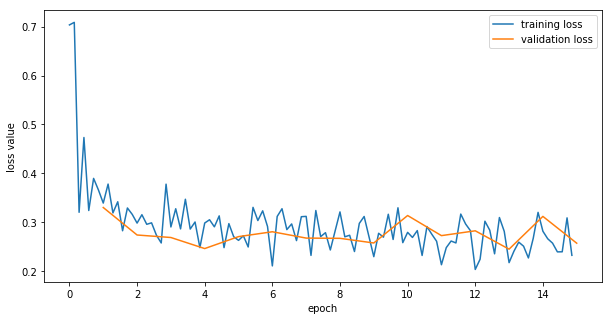

In [17]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.03,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()